# decoupleR
[decoupler](https://doi.org/10.1093/bioadv/vbac016) is a package containing different statistical methods to extract biological activities from omics data within a unified framework, including pathway activity inference and transcription factor activity inference.

In [this notebook](https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html) we show how to use [decoupler](https://decoupler-py.readthedocs.io/en/latest/) for TF activity inference with only the gene expression matrix. Follow [the instruction](https://decoupler-py.readthedocs.io/en/latest/installation.html) to install decoupler.

In [1]:
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from anndata import AnnData

import warnings
warnings.filterwarnings("ignore")

import session_info
session_info.show()

## Loading the CollecTRI network
CollecTRI is a comprehensive resource containing a curated collection of TFs and their transcriptional targets compiled from 12 different resources. The interactions are weighted by their mode of regulation (activation or inhibition).

In [2]:
net = dc.get_collectri(organism='human', split_complexes=False)

In [3]:
net.head()

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...


## Loading the scRNA-seq data
For this tutorial, we will analyze the a dataset of Peripheral Blood Mononuclear Cells (PBMC) freely available from [10X Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k). The processed 3k PBMC data can be downloaded using `scanpy`.

In [4]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Cells have been annotated.

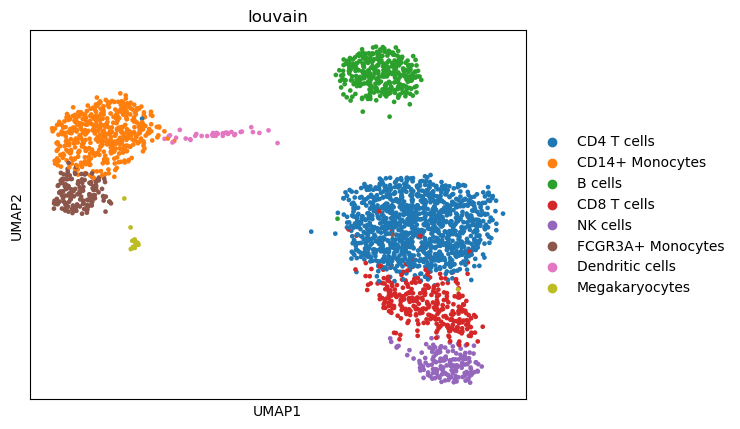

In [5]:
sc.pl.umap(adata, color='louvain')

## Activity inference with univariate linear model (ULM)
For each cell in `adata` and each TF in `net`, it fits a linear model that predicts the observed gene expression based solely on the TF-Gene interaction weights. Once fitted, the obtained $t$-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

In [6]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False)

Running ulm on mat with 2638 samples and 1838 targets for 233 sources.


The obtained scores `ulm_estimate` and $p$-values `ulm_pvals` are stored in the `.obsm` key.

In [7]:
adata.obsm['ulm_estimate'].head()

,AHR,AP1,APEX1,AR,ARNT,ATF1,ATF2,ATF3,ATF4,ATF6,...,VDR,WT1,XBP1,YBX1,YY1,ZBED1,ZBTB16,ZNF143,ZNF354C,ZNF699
AAACATACAACCAC-1,-0.713412,-0.796888,-0.414934,-0.384610,-0.427640,-0.251972,0.712485,0.765445,-0.555483,-0.242350,...,-0.487856,3.897006,-0.534836,-1.239583,-0.601814,-0.703833,0.014976,0.937554,-0.440790,-0.803361
AAACATTGAGCTAC-1,-1.178679,-0.649253,-0.386664,-0.223454,0.283640,-0.073837,-0.123670,-0.783482,-0.514562,-0.192497,...,-0.480924,-0.280991,-0.122216,0.503990,-0.676383,-0.943857,-0.756018,2.575000,0.609615,0.319354
AAACATTGATCAGC-1,0.093145,-1.108915,-0.389782,-0.379834,-0.025143,-0.289046,0.021652,1.271719,0.235626,-0.366816,...,-1.069986,-0.610919,-0.435170,-0.379842,-0.350343,0.111253,-0.707702,-1.362524,-0.484185,-1.006004
AAACCGTGCTTCCG-1,-1.151159,0.398437,0.723572,1.880048,-0.886856,-0.169556,-0.173997,-0.002894,-0.082539,-0.394638,...,0.102531,-0.612719,-0.531196,0.338513,-1.701111,-0.822069,0.244459,0.351947,-0.528722,0.958330
AAACCGTGTATGCG-1,-0.822002,1.835015,-0.381346,-0.358895,-1.001228,-0.497532,-0.377079,-2.155375,-0.683687,-0.328231,...,-0.729492,-1.395776,-0.300101,2.070392,0.633352,-0.491459,0.588488,0.354033,2.372365,2.319153


In [8]:
adata.obsm['ulm_pvals'].head()

,AHR,AP1,APEX1,AR,ARNT,ATF1,ATF2,ATF3,ATF4,ATF6,...,VDR,WT1,XBP1,YBX1,YY1,ZBED1,ZBTB16,ZNF143,ZNF354C,ZNF699
AAACATACAACCAC-1,0.475682,0.425619,0.678239,0.700571,0.668963,0.801091,0.476255,0.444105,0.578632,0.808536,...,0.625710,0.000101,0.592828,0.215288,0.547372,0.481626,0.988053,0.348597,0.659417,0.421870
AAACATTGAGCTAC-1,0.238679,0.516256,0.699050,0.823207,0.776719,0.941148,0.901590,0.433445,0.606921,0.847374,...,0.630628,0.778749,0.902741,0.614329,0.498882,0.345367,0.449735,0.010102,0.542192,0.749494
AAACATTGATCAGC-1,0.925799,0.267612,0.696743,0.704113,0.979944,0.772579,0.982728,0.203634,0.813749,0.713798,...,0.284766,0.541329,0.663490,0.704106,0.726122,0.911428,0.479220,0.173200,0.628313,0.314546
AAACCGTGCTTCCG-1,0.249817,0.690354,0.469421,0.060260,0.375273,0.865378,0.861887,0.997691,0.934227,0.693156,...,0.918346,0.540138,0.595347,0.735016,0.089092,0.411144,0.806903,0.724919,0.597062,0.338022
AAACCGTGTATGCG-1,0.411182,0.066665,0.702991,0.719715,0.316848,0.618874,0.706159,0.031262,0.494259,0.742775,...,0.465794,0.162951,0.764134,0.038555,0.526583,0.623160,0.556277,0.723355,0.017777,0.020496


## Visualization
Extract the activity matrix from the `adata` object.

In [9]:
adata_tfa = dc.get_acts(adata, obsm_key='ulm_estimate')
adata_tfa

AnnData object with n_obs × n_vars = 2638 × 233
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ulm_estimate', 'ulm_pvals'

PAX5 is a master regulator of B cell development. First we correlate the inferred TFa of PAX5 and the mRNA expression of marker genes of B cells. Then we cluster the cells based on inferred TF activity and mRNA expression.

In [10]:
from scipy.stats import pearsonr
pearsonr(adata.to_df().loc[:, 'CD19'], adata_tfa.to_df().loc[:, 'PAX5'])

PearsonRResult(statistic=0.48427925672059924, pvalue=3.3559999424770023e-155)

### Clustering cells based on TF activity

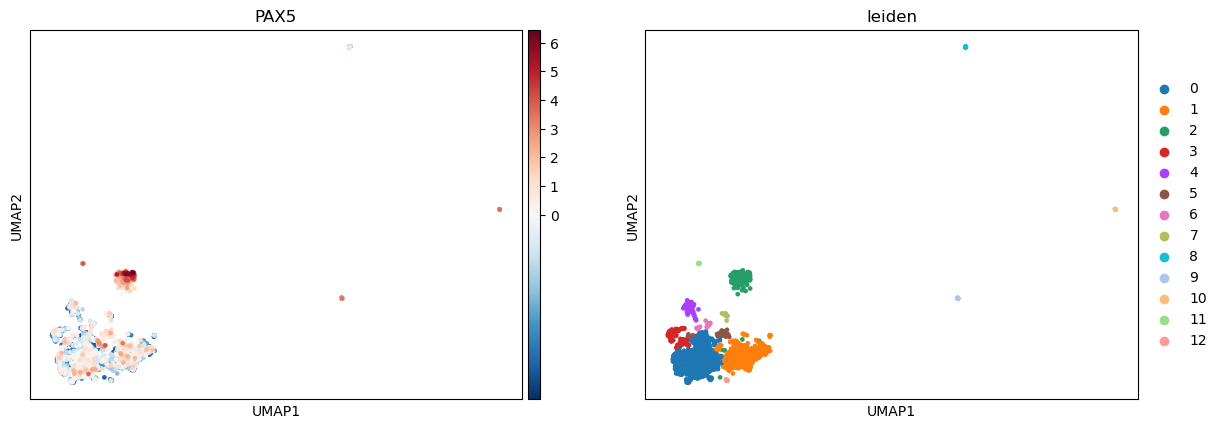

In [12]:
adata_tfa_scaled = adata_tfa.copy()
sc.pp.scale(adata_tfa_scaled)
sc.pp.neighbors(adata_tfa_scaled, use_rep='X', n_neighbors=100)
sc.tl.umap(adata_tfa_scaled, min_dist=0.01)
sc.tl.leiden(adata_tfa_scaled, resolution=0.6)
sc.pl.umap(adata_tfa_scaled, color=['PAX5', 'leiden'], cmap='RdBu_r', vcenter=0)

### Clustering cells based on mRNA expression

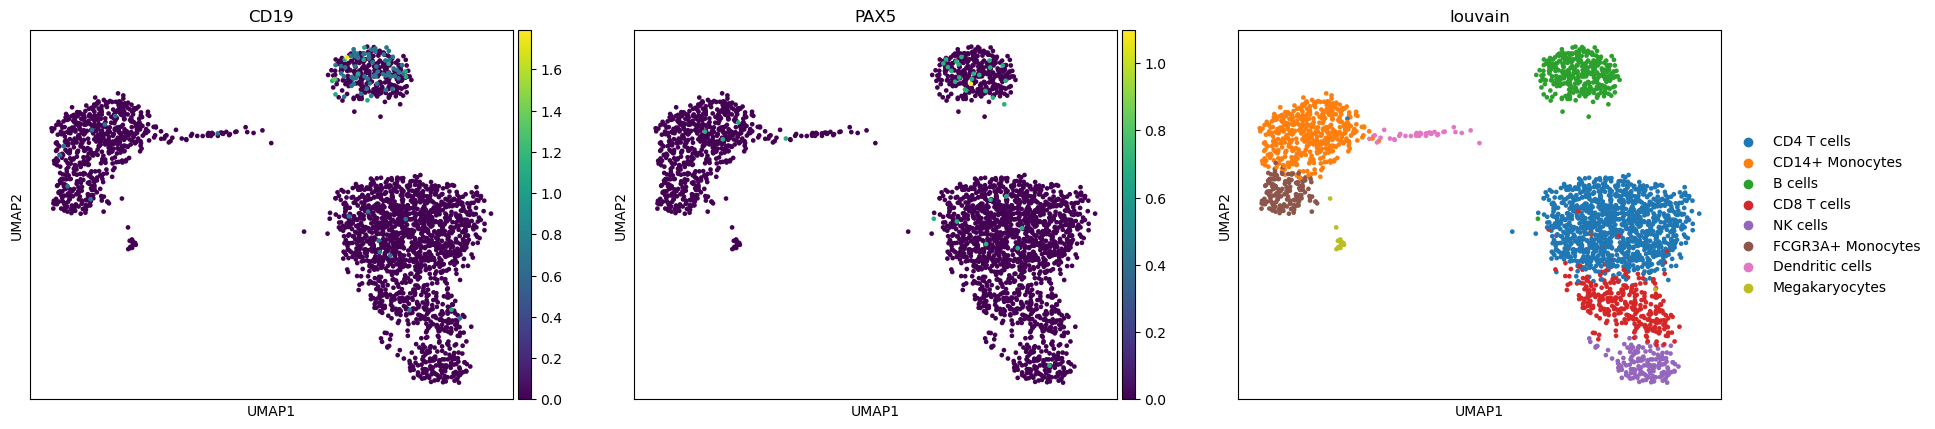

In [13]:
sc.pl.umap(adata, color=['CD19', 'PAX5', 'louvain'])

### Celltype-specific TFs
First we identify the top TFs by cell type. Then we extract and visualize the top 3 markers per cell type.

In [14]:
df = dc.rank_sources_groups(adata_tfa, groupby='louvain', 
                            reference='rest', method='t-test_overestim_var')

In [15]:
df.head()

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cells,rest,RFXANK,42.000939,4.686653,7.153321e-191,1.666724e-188
1,B cells,rest,RFXAP,40.961164,4.639178,5.682885e-186,6.620561e-184
2,B cells,rest,RFX5,39.572243,4.472046,1.410242e-177,1.095288e-175
3,B cells,rest,CIITA,34.090930,3.268771,7.860726e-148,4.578873e-146
4,B cells,rest,EBF1,32.980943,3.049097,4.195577e-120,1.955139e-118


In [16]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()

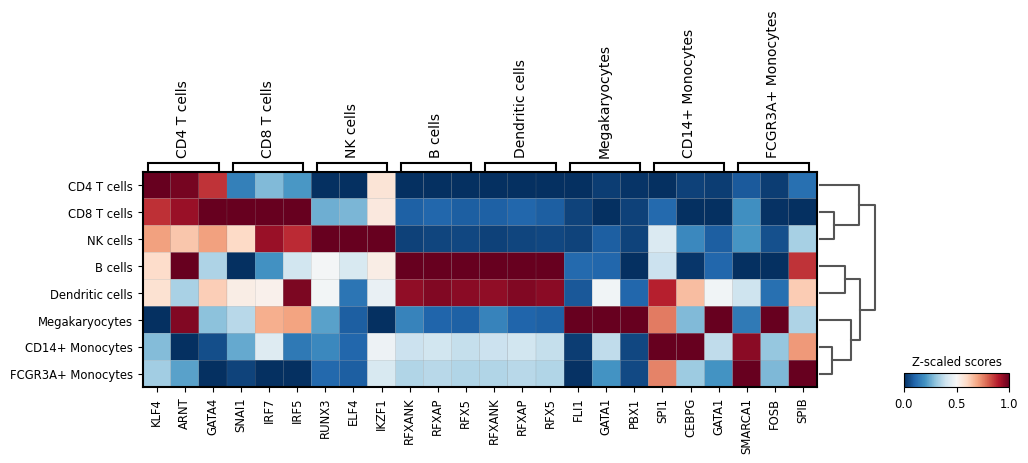

In [17]:
sc.pl.matrixplot(adata_tfa, source_markers, 'louvain', 
                 dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

## Saving results to file

In [20]:
!mkdir outputs_decoupler
adata.write('outputs_decoupler/pbmc3k.h5ad')